In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

In [8]:
torch.cuda.is_available()

False

In [9]:
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

BATCH_SIZE=64
N_EPOCHS=150
IMAGE_SIZE = 28*28 # 784
LATENT_DIM = 100
PRINT_EVERY=5
N_SHOW=5

dim_of_latent = torch.randn(BATCH_SIZE,LATENT_DIM)

cpu


### Step-1 :

In [4]:
# transformation of the dataset
transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))

])

# loading dataset
data = datasets.MNIST('dataset',train=True,download=True,transform=transforms)

data_iter = DataLoader(data,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
print(data_iter)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:11<00:00, 835816.42it/s] 


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 104726.06it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:03<00:00, 445625.08it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2115315.21it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### Step-2 : Model

In [20]:
 #  Generator (MLP)
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, z):
        return self.main(z)


# Discriminator (MLP)
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(image_size, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),

            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x).view(-1)


In [21]:
G = Generator(LATENT_DIM,IMAGE_SIZE).to(device)
D = Discriminator(IMAGE_SIZE).to(device)

### Step-3 : Training

In [22]:
# loss function for GANs Training ?
criterion=nn.BCELoss()

# Optimizers
G_optimizer = optim.Adam(G.parameters(),lr=0.0005,betas=(0.5,0.999))
D_optimizer = optim.Adam(D.parameters(),lr=0.0005,betas=(0.5,0.999))

# labels will be 1 for real and 0 for fake
real_labels = torch.ones(BATCH_SIZE,).to(device)
fake_labels = torch.zeros(BATCH_SIZE,).to(device)

# function epoch time ?
def epochs(start_time, end_time):
    diff = end_time - start_time
    diff_mins = int(diff/60)
    diff_secs = int(diff - (diff_mins)*60)
    return diff_mins, diff_secs

In [23]:
os.makedirs("images/gan", exist_ok=True)

In [24]:
for epoch in range(1, N_EPOCHS + 1):

    start_time = time.time()
    D_running_loss, G_running_loss = 0.0, 0.0
    for x, _ in data_iter:   # iterate directly over dataloader
        # Move real images to device
        x = x.to(device)
        x = x.view(-1, IMAGE_SIZE)

        batch_size = x.size(0)

        # Create labels for this batch
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # ===================== #
        #   Train Discriminator #
        # ===================== #
        D.zero_grad()

        # Real images
        pred_real = D(x)
        D_loss_real = criterion(pred_real, real_labels)

        # Fake images
        z = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_images = G(z).detach()   # stop gradient to G
        pred_fake = D(fake_images)
        D_loss_fake = criterion(pred_fake, fake_labels)

        # Total discriminator loss
        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # ================= #
        #   Train Generator #
        # ================= #
        G.zero_grad()

        z = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_images = G(z)
        pred_fake = D(fake_images)

        # Generator wants D to predict real
        G_loss = criterion(pred_fake, real_labels)

        G_loss.backward()
        G_optimizer.step()
    
    D_running_loss += D_loss.item()
    G_running_loss += G_loss.item()
    end_time = time.time()

    epoch_mins, epoch_secs = epochs(start_time, end_time)

    # Average losses over dataset
    D_avg_loss = D_running_loss / len(data_iter)
    G_avg_loss = G_running_loss / len(data_iter)

    if (epoch % PRINT_EVERY) == 0:
        # Sample noise
        z = torch.randn(N_SHOW * N_SHOW, LATENT_DIM, device=device)

        # Generate images
        with torch.no_grad():
            generated_images = G(z).view(-1, 1, 28, 28)

        # Save images
        save_path = f"images/gan/epoch{epoch:03}.png"
        torchvision.utils.save_image(
            generated_images,
            save_path,
            nrow=N_SHOW,
            normalize=True
        )

        # Print epoch stats
        print(f"| Epoch: {epoch:03} | D_loss: {D_avg_loss:.3f} | G_loss: {G_avg_loss:.3f} "
              f"| Time: {epoch_mins}m {epoch_secs}s")


| Epoch: 005 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 16s
| Epoch: 010 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 015 | D_loss: 0.002 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 020 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 16s
| Epoch: 025 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 030 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 035 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 040 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 045 | D_loss: 0.002 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 050 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 055 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 14s
| Epoch: 060 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 065 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 14s
| Epoch: 070 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 15s
| Epoch: 075 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 16s
| Epoch: 080 | D_loss: 0.001 | G_loss: 0.001 | Time: 0m 16s
| Epoch: 085 | D_loss: 0.002 | G_loss: 0

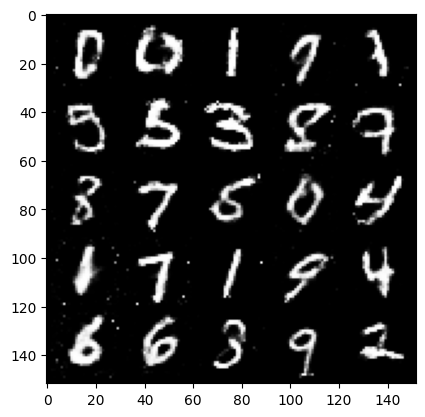

In [26]:
#display images
img = plt.imread(f'images/gan/epoch{epoch:03}.png')
plt.imshow(img)
plt.show()

In [25]:
from PIL import Image
import os

image_dir = "images/gan"
gif_path = "gan_training.gif"

# Collect sorted images
filenames = sorted([f for f in os.listdir(image_dir) if f.endswith(".png")])

# Open all images
frames = [Image.open(os.path.join(image_dir, f)) for f in filenames]

# Save as GIF
frames[0].save(
    gif_path,
    save_all=True,
    append_images=frames[1:],
    duration=300,   # milliseconds per frame
    loop=0          # 0 = loop forever
)

print(f"GIF saved at {gif_path}")


GIF saved at gan_training.gif


In [27]:
# Save both Generator and Discriminator
torch.save(G.state_dict(), "G.pth")
torch.save(D.state_dict(), "D.pth")

print("✅ Models saved!")


✅ Models saved!


In [28]:
# Recreate model with same architecture
G = Generator(LATENT_DIM, IMAGE_SIZE).to(device)
G.load_state_dict(torch.load("G.pth", map_location=device))
G.eval()  # very important for BatchNorm/Dropout layers


Generator(
  (main): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=512, out_features=1024, bias=True)
    (7): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Linear(in_features=1024, out_features=784, bias=True)
    (10): Tanh()
  )
)

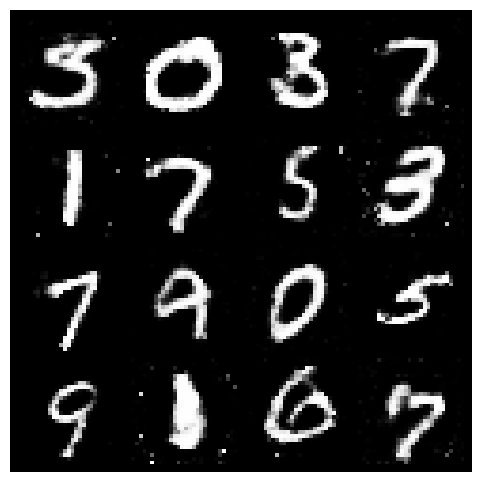

In [29]:
import torchvision
import matplotlib.pyplot as plt

# Sample noise (say, 16 images = 4x4 grid)
z = torch.randn(16, LATENT_DIM, device=device)

# Generate fake images
with torch.no_grad():
    fake_images = G(z).view(-1, 1, 28, 28)

# Save grid
torchvision.utils.save_image(
    fake_images,
    "generated_sample_1.png",
    nrow=4,
    normalize=True
)

# Display
grid_img = torchvision.utils.make_grid(fake_images, nrow=4, normalize=True)
plt.figure(figsize=(6,6))
plt.imshow(grid_img.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()


In [30]:
D = Discriminator(IMAGE_SIZE).to(device)
D.load_state_dict(torch.load("D.pth"))
D.eval()


Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)